In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Indlæs data

loc1 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_polar2_fixed.csv"

column_names = ['Date', 'North', 'South', 'Average', 'val4', 'colon', 'val5', 'val6', 'val7']
wso_raw_data = pd.read_csv(loc1, names=column_names, delimiter=',')

# WSO data
wso_date_arr = wso_raw_data['Date'].values
wso_north_arr = wso_raw_data['North'].values.astype(float)
wso_south_arr = wso_raw_data['South'].values.astype(float)
wso_average_arr = wso_raw_data['Average'].values.astype(float)

# Konverter til absolutværdi af gennemsnit
wso_average_arr = np.abs(wso_average_arr)



In [93]:
# Konverter datoer til brøkdele af år (ignorer dagen data blev taget på)
wso_date_fraction_arr = np.zeros(len(wso_date_arr))
for i in range(len(wso_date_arr)):
    date = wso_date_arr[i]
    year = int(date[:4])
    month = int(date[5:7])
    day = 1
    wso_date_fraction_arr[i] = year + (30.4375 * (month - 1) + day) / 365.25


# Lav et dictionary med formatet {fractional_date: [gennemsnit, gennemsnit, ...]} for alle gennemsnit med samme dato
wso_date_dict = {}
for i in range(len(wso_date_fraction_arr)):
    if wso_date_fraction_arr[i] in wso_date_dict:
        wso_date_dict[wso_date_fraction_arr[i]].append(wso_average_arr[i])
    else:
        wso_date_dict[wso_date_fraction_arr[i]] = [wso_average_arr[i]]



# Omregn til gennemsnit
for key, value in wso_date_dict.items():
    wso_date_dict[key] = np.mean(value)




In [94]:
# 13 måneders glidende gennemsnit alle datapunkter vægtet med 1, første og sidste måned vægtet med 0.5
# Ingen data for de første 6 og sidste 6 måneder
def monthly_smoothed_13(data):
    smoothed_data = np.zeros(len(data))
    for i in range(6, len(data) - 6):
        smoothed_data[i] = (0.5 * data[i - 6] + data[i - 5] + data[i - 4] + data[i - 3] + data[i - 2] + data[i - 1] + data[i] + data[i + 1] + data[i + 2] + data[i + 3] + data[i + 4] + data[i + 5] + 0.5 * data[i + 6]) / 13

    # Slet de første og sidste 6 måneder
    smoothed_data = smoothed_data[6:-6]

    return smoothed_data


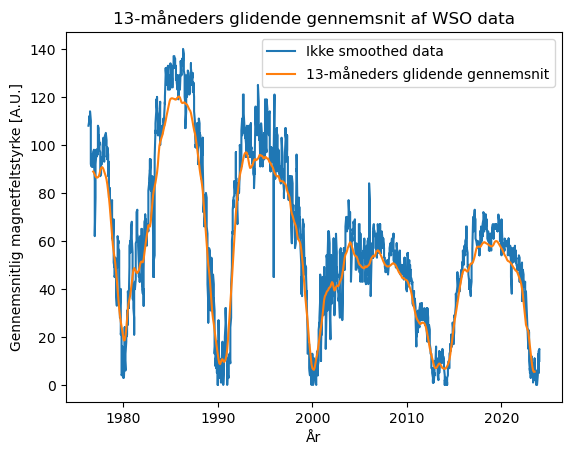

In [98]:
monthly_averaged_date, monthly_averaged_wso = zip(*(wso_date_dict.items()))

# 13-måneders glidende gennemsnit af magnetfeltsdata
monthly_averaged_wso = monthly_smoothed_13(monthly_averaged_wso)

# Slet de første og sidste 6 måneder af datoer
monthly_averaged_date = monthly_averaged_date[6:-6]

# Plot data sammen med ikke smoothed data
plt.plot(wso_date_fraction_arr, wso_average_arr, label='Ikke smoothed data')
plt.plot(monthly_averaged_date, monthly_averaged_wso, label='13-måneders glidende gennemsnit')
plt.xlabel('År')
plt.ylabel('Gennemsnitlig magnetfeltstyrke [A.U.]')
plt.title('13-måneders glidende gennemsnit af WSO data')
plt.legend()
plt.show()



In [100]:
# Gem magnetfeltsdata i en fil
loc2 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_smoothed.csv"
with open(loc2, 'w') as file:
    file.write('Dato (brøkdel), Magnetfeltsstyrke\n')
    for i in range(len(monthly_averaged_date)):
        file.write(str(monthly_averaged_date[i]) + ',' + str(monthly_averaged_wso[i]) + '\n')
    file.close()

